# Natality project: predictive analysis #

This is the continuation of the Machine Learning section of the Natality project. See details and other parts on [Github](https://github.com/bd3thier/Natality-project).

## 2. Classification Models ##

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
# Load dataset
data = pd.read_csv('data/df_dummy_var_log_transfo.csv')
data.head()

,mother_age,total_birth_order,month_prenatal_care_began,mother_height,prepregnancy_weight,previous_cesareans,plural_birth,obstetric_estimate,birth_month-10,birth_month-11,...,interval-0,interval-1,interval-2,interval-3,interval-4,interval-5,interval-6,interval-7,interval-8,interval-9
0,30,4,3,66,5.247024,0,1,40,0,0,...,False,False,False,True,False,False,False,False,False,False
1,28,2,5,71,5.370638,0,1,36,0,0,...,False,False,False,False,False,False,False,False,True,False
2,23,3,5,64,4.927254,0,1,39,0,0,...,False,False,False,False,False,True,False,False,False,False
3,26,2,2,67,5.298317,0,1,39,0,0,...,False,False,False,False,False,True,False,False,False,False
4,31,1,3,67,5.192957,0,1,40,0,0,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# Create label column
data['premature'] = data.obstetric_estimate.between(0, 36)
df=data.drop('obstetric_estimate', axis = 1)

In [4]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X = df.drop(['premature'], axis = 1)
y = df.premature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 2, 
                                                    stratify = y)

In [5]:
# Check percentage of premature births
print('Percentage of premature births:', np.round(y.value_counts()[1]/y.count()*100, 2), '%')

Percentage of premature births: 8.33 %


### 1. Linear Classifiers: Logistic Regression and linear SVM

We start with a simple logistic regression using the default parameters to have an idea.

In [6]:
# This creates a LogisticRegression object
lg = LogisticRegression()
lg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
# Fit the model
lg.fit(X_train, y_train)

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
#Predict labels and probabilities of test set
predictions = lg.predict(X_test)
proba = lg.predict_proba(X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.71


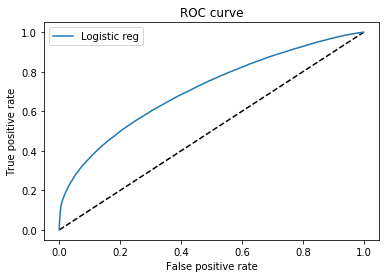

In [11]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic reg')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Confusion matrix:  [[525548   2418]
 [ 42395   5495]]


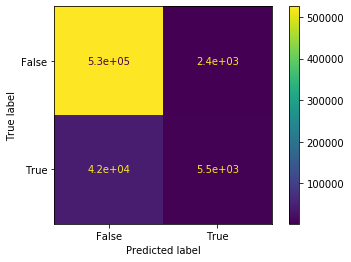

In [9]:
#Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('Confusion matrix: ', confusion_matrix)
metrics.plot_confusion_matrix(lg, X_test, y_test)

In [16]:
precision = metrics.precision_score(y_test, predictions)
print('Precision : {0:0.3f}'.format(precision))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.690
Recall : 0.109
Accuracy :  0.922


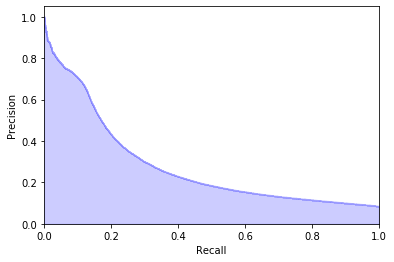

In [15]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]) 
plt.show()

The area under the curve is 0.71, which is a good start. Let's try to optimize the hyperparameter and see how it performs.

#### Tune Hyperparameters

We can tune simultaneously for the two linear classifiers: logistic regression (loss = log) and linear SVM (loss = hinge)

In [12]:
from sklearn.linear_model import SGDClassifier

# We set random_state=2 for reproducibility 
linear_classifier = SGDClassifier(random_state=2)

# Instantiate the GridSearchCV object and run the search
grid_parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, grid_parameters, cv=3, verbose = 1, n_jobs = -1)
searcher.fit(X_train, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.8min finished


Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
Best CV accuracy 0.9220518254270723
Test accuracy of best grid search hypers: 0.9219422911283376


The hinge loss is preferred, meaning an SVM type of model. We can compare the performances with the logistic regression of-the-shelf:

In [16]:
best_sgd = searcher.best_estimator_
best_sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=2, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [19]:
#Predict labels and probabilities of test set
predictions = best_sgd.predict(X_test)
proba = best_sgd.predict_proba(X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.69


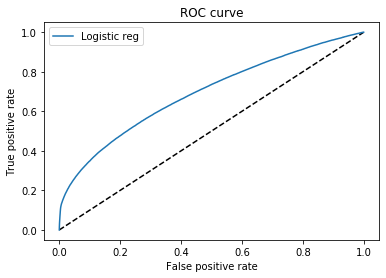

In [20]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic reg')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.691
Recall : 0.116
Accuracy :  0.922


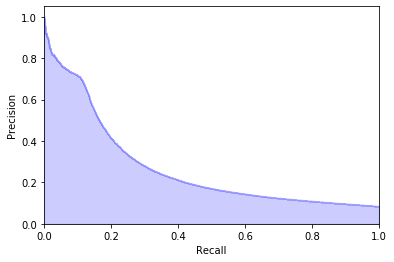

In [21]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]) 
plt.show()

Even after optimization the area under the curve is 0.69 (0.5 is a random classification). We can try to standardize the features to improve more, then move on to other, non-linear models.

#### Standardize features

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

In [23]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(solver='liblinear', penalty='l1')

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(lr, {'C':[.0001, 0.001, 0.01, 0.1, 1, 10]}, cv=3, verbose = 1, n_jobs = -1)
searcher.fit(standardized_X, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  5.5min finished


Best CV params {'C': 0.001}
Total number of features: 87
Number of selected features: 45


In [29]:
#Predict labels and probabilities of test set
predictions = best_lr.predict(standardized_X_test)
proba = best_lr.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.71


In [30]:
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.695
Recall : 0.115
Accuracy :  0.922


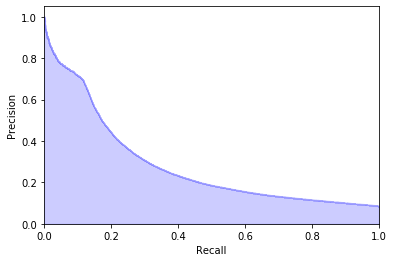

In [31]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]) 
plt.show()

In [26]:
# Make arrays with only the important features
important_features_indices = np.where(coefs != 0)
important_X_train = standardized_X[:, important_features_indices[1]]
important_X_test = standardized_X_test[:, important_features_indices[1]]

In [27]:
# Sanity check
important_X_train.shape

(1343662, 45)

The logistic regression is slightly improved by standardization.

We are not going to use the list of important features right now, but go back to the general linear classifier. We want to optimize it on the standardized set as well to compare performances (Gridsearch for SGD classifier on the standardized_X_train):

In [28]:
from sklearn.linear_model import SGDClassifier

# We set random_state=2 for reproducibility 
linear_classifier = SGDClassifier(random_state=2)

# Instantiate the GridSearchCV object and run the search
grid_parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}
searcher = GridSearchCV(linear_classifier, grid_parameters, cv=3, verbose = 1, n_jobs = -1)
searcher.fit(standardized_X, y_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)
print("Test accuracy of best grid search hypers:", searcher.score(standardized_X_test, y_test))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.5min finished


Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l1'}
Best CV accuracy 0.9221746241417117
Test accuracy of best grid search hypers: 0.9221315745603067


In [32]:
best_sgd = searcher.best_estimator_
#Predict labels and probabilities of test set
predictions = best_sgd.predict(standardized_X_test)
proba = best_sgd.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.71


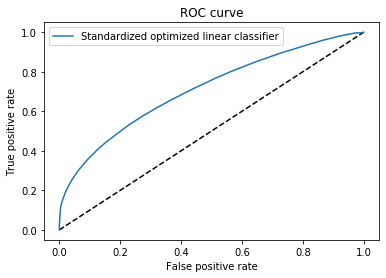

In [33]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Standardized optimized linear classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [21]:
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.697
Recall : 0.116
Accuracy :  0.922


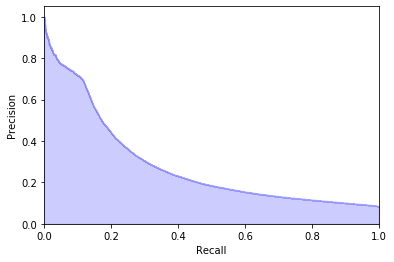

In [35]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]) 
plt.show()

Optimization and standardization of linear classifiers did not improve the performances that much. We move to a different type of classifier.

### 2. k Nearest Neighbors ###

In [6]:
# Take 10% of the dataset because it would be too long to train on the full set (see documentation, 'impractical beyond tens of thousands of samples)')
# Then we changed to 5% because it was still too slow but did not change the name of the variable!
np.random.seed(2)
subdf5, subdf95 = np.split(df.sample(frac=1), [int(.05*len(df))])
subdf5.shape

(95975, 88)

In [7]:
# Split train and test set for 5% of the dataset
from sklearn.model_selection import train_test_split

X5 = subdf5.drop(['premature'], axis = 1)
y5 = subdf5.premature
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.3, random_state= 2)

In [8]:
# Standardize 5% of the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X5_train)
standardized_X5 = scaler.transform(X5_train)
standardized_X5_test = scaler.transform(X5_test)

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
grid_parameters = {'n_neighbors': [5,11,19], 'weights': ['uniform', 'distance']}
searcher= GridSearchCV(knn, grid_parameters, verbose = 1, cv = 3, n_jobs = 4)
knnB = searcher.fit(standardized_X5, y5_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  9.5min finished


In [11]:
# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(standardized_X5_test, y5_test))

Best CV params {'n_neighbors': 19, 'weights': 'distance'}
Best CV accuracy 0.9218838379327797
Test accuracy of best grid search hypers: 0.9197027055187025


In [13]:
knn = KNeighborsClassifier(n_neighbors= 19, weights= 'distance' , n_jobs = 8)
knn.fit(standardized_X5, y5_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=19, p=2,
                     weights='distance')

In [14]:
#Predict labels and probabilities of test set
predictions = knn.predict(standardized_X_test)
proba = knn.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.65


In [15]:
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.65


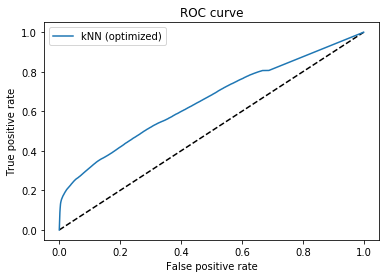

In [16]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='kNN (optimized)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

kNN (optimized) confusion matrix:  [[525831   2078]
 [ 41691   6256]]


(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('0', '0'), (0.0, 0.0, 0.8730836809731533, 0.9639326279290927)),
              (('0', '1'),
               (0.0,
                0.9961906924452217,
                0.8730836809731533,
                0.003809307554778378)),
              (('1', '0'),
               (0.9207027285922009,
                0.0,
                0.07929727140779906,
                0.8414734818082062)),
              (('1', '1'),
               (0.9207027285922009,
                0.8737315463243354,
                0.07929727140779906,
                0.12626845367566478))]))

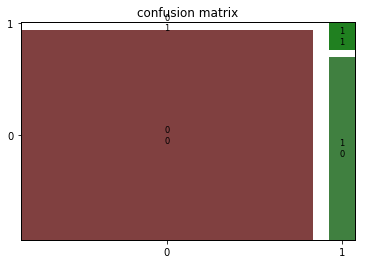

In [17]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('kNN (optimized) confusion matrix: ', confusion_matrix)
mosaic(confusion_matrix, gap=0.05, title='confusion matrix')

In [18]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.751
Recall : 0.13
Accuracy :  0.924


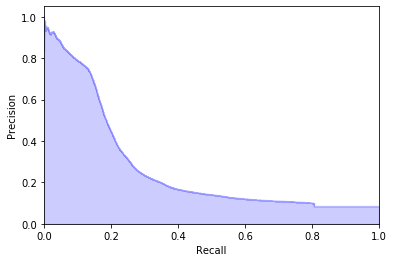

In [19]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post', label='kNN (optimized)')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])

plt.xlim([0.0, 1.0]) 
plt.show()

kNN doesn't do as well as a logistic regression. We move on to non-linear SVM.

### 3. SVM - non linear kernels

In [20]:
from sklearn.svm import SVC

In [10]:
from sklearn.model_selection import GridSearchCV
# Instantiate an SVM
svm = SVC()

# Instantiate the GridSearchCV object and run the search
grid_parameters = {'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma':[0.00001, 0.001, 0.1], 'C': [0.01, 1, 100]}
searcher = GridSearchCV(svm, grid_parameters, cv = 3, verbose = 1, n_jobs = -1)
searcher.fit(standardized_X10, y10_train)

# Report the best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(standardized_X5_test, y5_test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 171.9min finished


Best CV params {'C': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}
Best CV accuracy 0.922806704176714
Test accuracy of best grid search hypers: 0.9209530094120099


In [24]:
svm = SVC(C= 1, gamma= 0.001, kernel= 'sigmoid', probability=True)
svm.fit(standardized_X5, y5_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [25]:
#Predict labels and probabilities of test set
predictions = svm.predict(standardized_X_test)
proba = svm.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

Area under ROC = 0.56


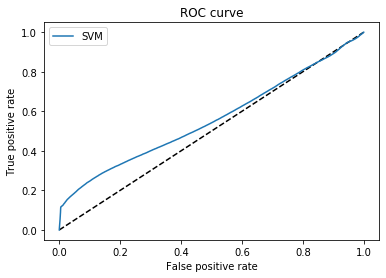

In [26]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

SVM confusion matrix:  [[525384   2525]
 [ 42407   5540]]


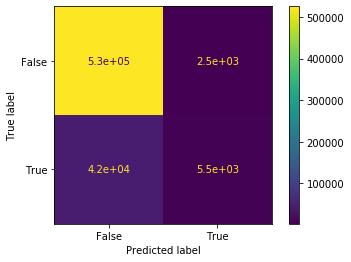

In [27]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('SVM confusion matrix: ', confusion_matrix)
metrics.plot_confusion_matrix(svm, standardized_X_test, y_test)

In [28]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Average Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy score: ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.687
Average Recall : 0.116
Accuracy score:  0.922


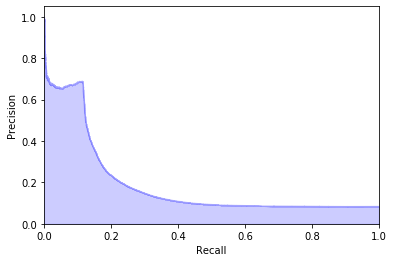

In [29]:
# Plot precision recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, proba[:,1])
plt.step(recall, precision, color='b', alpha=0.2, where='post', label='SVM')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]) 
plt.show()

This model perform worse than it's linear counterpart. Computation time is scarce so we will not spend more time on SVM.

### 4. Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
# Create and fit the classifier
rf = RandomForestClassifier(verbose = 1, n_jobs = -1)
rf.fit(standardized_X, y_train)
#takes xx min to train

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [32]:
# Prediction test labels
predictions = rf.predict(standardized_X_test)
proba = rf.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.9s


Area under ROC = 0.69


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.1s finished


Area under ROC = 0.69


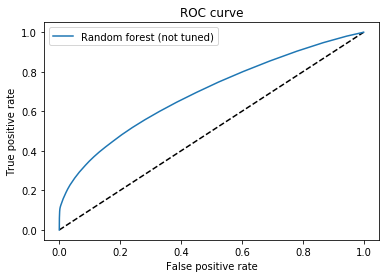

In [33]:
#Plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (not tuned)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

RF confusion matrix:  [[526296   1613]
 [ 42435   5512]]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.3s finished


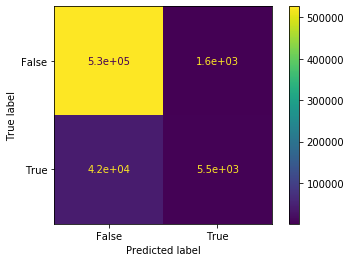

In [35]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('RF confusion matrix: ', confusion_matrix)
metrics.plot_confusion_matrix(rf, standardized_X_test, y_test)

In [26]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.774
Recall : 0.115
Accuracy :  0.924


The random forest gives the best result so far. Let's tune the hyperparameters

In [27]:
forest = RandomForestClassifier()

In [28]:
n_estimators = [100, 500, 1200]
max_depth = [5, 15, 30]
min_samples_split = [2, 10, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)

In [29]:
gridF.fit(standardized_X, y_train)
gridF.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 67.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 589.6min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 1462.9min finished


{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [31]:
forest_params= gridF.best_params_

In [36]:
forest = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, 
           n_estimators = 1200, verbose = 1, n_jobs = -1)
forest.fit(standardized_X, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 20.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [37]:
# Prediction test labels
predictions = forest.predict(standardized_X_test)
proba = forest.predict_proba(standardized_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   24.8s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   37.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   13.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   24.8s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   37.9s finished


Area under ROC = 0.72


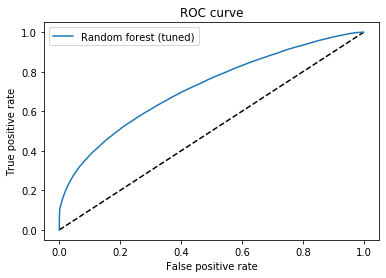

In [38]:
#Plot ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (tuned)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

RF confusion matrix:  [[526320   1589]
 [ 42409   5538]]


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.4s finished


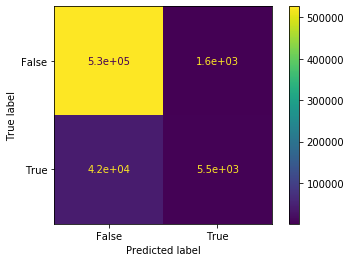

In [63]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('RF confusion matrix: ', confusion_matrix)
metrics.plot_confusion_matrix(rf, standardized_X_test, y_test)

In [64]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.777
Recall : 0.116
Accuracy :  0.924


The improvement from optimization is barely noticeable!

We will select the features by importance to optimize again and hopefully improve the model:

In [41]:
# List of features for later use
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(forest.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: plural_birth         Importance: 0.1224
Variable: prepregnancy_weight  Importance: 0.1066
Variable: mother_age           Importance: 0.0847
Variable: mother_height        Importance: 0.0709
Variable: month_prenatal_care_began Importance: 0.0575
Variable: total_birth_order    Importance: 0.0443
Variable: previous_preterm_birth-Y Importance: 0.0217
Variable: no_risk_factors-1    Importance: 0.0203
Variable: sex-M                Importance: 0.0167
Variable: WIC-Y                Importance: 0.0157
Variable: payment-2            Importance: 0.0126
Variable: mother_education-3   Importance: 0.0122
Variable: mother_education-4   Importance: 0.0115
Variable: mother_nativity-2    Importance: 0.0109
Variable: birth_month-7        Importance: 0.0096
Variable: birth_month-8        Importance: 0.0095
Variable: birth_month-10       Importance: 0.0093
Variable: birth_month-12       Importance: 0.0093
Variable: birth_month-5        Importance: 0.0093
Variable: father_education-3   Importance

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

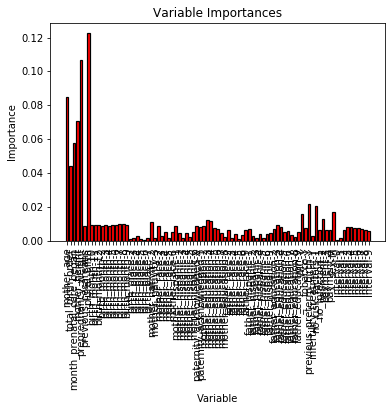

In [42]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

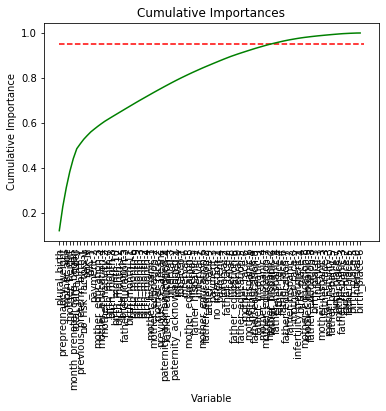

In [43]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [44]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
features95 = np.where(cumulative_importances > 0.95)[0][0] + 1
print('Number of features for 95% importance:', features95)

Number of features for 95% importance: 62


In [45]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:features95]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_X_train = standardized_X[:,important_indices]
important_X_test = standardized_X_test[:,important_indices]
# Sanity check on operations
print('Important train features shape:', important_X_train.shape)
print('Important test features shape:', important_X_test.shape)

Important train features shape: (1343662, 62)
Important test features shape: (575856, 62)


In [46]:
# Create and train the expanded model on only the important features
forest2 = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, 
                                 n_estimators = 1200, verbose = 1, n_jobs = -1)
forest2.fit(important_X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 16.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [47]:
# Prediction test labels
predictions = forest2.predict(important_X_test)
proba = forest2.predict_proba(important_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   27.2s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   41.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   14.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   27.0s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   41.3s finished


Area under ROC = 0.71


Area under ROC = 0.71


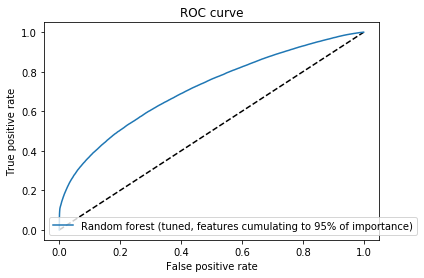

In [48]:
#Plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (tuned, features cumulating to 95% of importance)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [49]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.779
Recall : 0.115
Accuracy :  0.924


The difference is very small, we mihgt be able to eliminate even more features useless in predicting the term of birth. Let's try features combined to reach 80% of importance.

In [50]:
# Find number of features for cumulative importance of 80%
# Add 1 because Python is zero-indexed
features80 = np.where(cumulative_importances > 0.8)[0][0] + 1
print('Number of features for 80% importance:', features80)

Number of features for 80% importance: 36


In [51]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:features80]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important80_X_train = standardized_X[:,important_indices]
important80_X_test = standardized_X_test[:,important_indices]
# Sanity check on operations
print('80% important train features shape:', important80_X_train.shape)
print('80% important test features shape:', important80_X_test.shape)

80% important train features shape: (1343662, 36)
80% important test features shape: (575856, 36)


In [52]:
# Create and train the expanded model on only the important features
forest3 = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, 
                                 n_estimators = 1200, verbose = 1, n_jobs = -1)
forest3.fit(important80_X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 14.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [54]:
# Prediction test labels
predictions = forest3.predict(important80_X_test)
proba = forest3.predict_proba(important80_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   16.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   28.9s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   44.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   16.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   28.7s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   43.7s finished


Area under ROC = 0.7


Area under ROC = 0.7


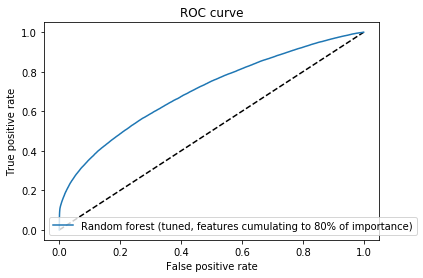

In [55]:
#Plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (tuned, features cumulating to 80% of importance)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [56]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.773
Recall : 0.115
Accuracy :  0.924


There is still no loss of performance. Let's see if we can remove even more features:

In [57]:
# Find number of features for cumulative importance of 70%
# Add 1 because Python is zero-indexed
# Erase features80 because needs too much RAM otherwise
features80 = np.where(cumulative_importances > 0.7)[0][0] + 1
print('Number of features for 70% importance:', features80)

Number of features for 70% importance: 24


In [58]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:features80]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important80_X_train = standardized_X[:,important_indices]
important80_X_test = standardized_X_test[:,important_indices]
# Sanity check on operations
print('70% important train features shape:', important80_X_train.shape)
print('70% important test features shape:', important80_X_test.shape)

70% important train features shape: (1343662, 24)
70% important test features shape: (575856, 24)


In [59]:
# Create and train the expanded model on only the important features
forest3 = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, 
                                 n_estimators = 1200, verbose = 1, n_jobs = -1)
forest3.fit(important80_X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 11.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [60]:
# Prediction test labels
predictions = forest3.predict(important80_X_test)
proba = forest3.predict_proba(important80_X_test)
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   30.6s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   46.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   16.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done 1200 out of 1200 | elapsed:   45.8s finished


Area under ROC = 0.68


Area under ROC = 0.68


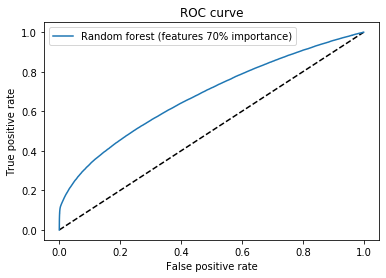

In [62]:
#Plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (features 70% importance)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [20]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.745
Recall : 0.117
Accuracy :  0.923


In [17]:
forest4 = RandomForestClassifier(verbose = 1)
n_estimators = [1200]
max_depth = [20, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest4, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
gridF.fit(important80_X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 264.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 44.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [18]:
gridF.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [63]:
forest4 = RandomForestClassifier(max_depth= 30, min_samples_leaf= 1, min_samples_split= 2, 
                                 n_estimators= 1200, verbose = 1)
forest4.fit(important80_X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed: 51.1min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=1, warm_start=False)

In [64]:
# Prediction test labels
predictions = forest4.predict(important80_X_test)
proba = forest4.predict_proba(important80_X_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  3.2min finished


Area under ROC = 0.68


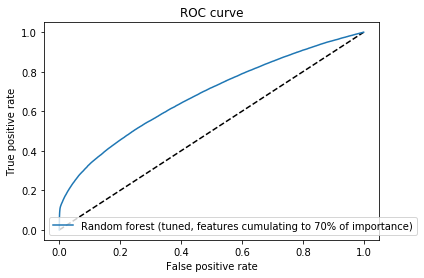

In [65]:
#Plot ROC
# Assess performance: ROC and AUC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random forest (tuned, features cumulating to 70% of importance)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.747
Recall : 0.117
Accuracy :  0.923


The best result we achieved with random forest classifiers was when all the features were used and the hyperpartameters were tuned, and the result is not very far from the off-the-shelf model. 

We will try a Naive Bayes classifier then Catboost.


### 5. Naive Bayes

In [67]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(standardized_X, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [68]:
# Prediction test labels
predictions = NB.predict(standardized_X_test)
proba = NB.predict_proba(standardized_X_test)

Area under ROC = 0.68


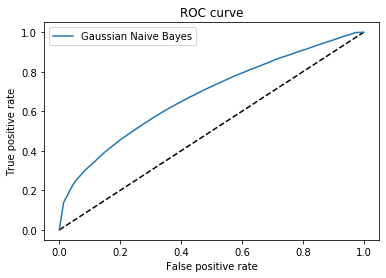

In [69]:
#Plot ROC
fpr, tpr, _ = metrics.roc_curve(y_test, proba[:,1])
auc = metrics.auc(fpr, tpr)
print('Area under ROC =', np.round(auc, 2))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Gaussian Naive Bayes')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [70]:
# Print precision, recall and accuracy score
print('Precision : {0:0.3f}'.format(metrics.precision_score(y_test, predictions)))
print('Recall :', np.round(metrics.recall_score(y_test, predictions),3))
print('Accuracy : ',np.round(metrics.accuracy_score(y_test, predictions),3))

Precision : 0.174
Recall : 0.444
Accuracy :  0.779


RF confusion matrix:  [[427015 100894]
 [ 26639  21308]]


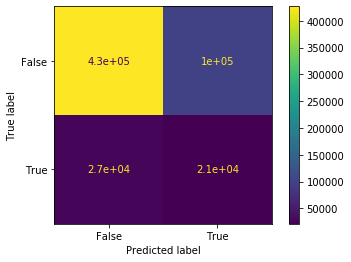

In [33]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print('RF confusion matrix: ', confusion_matrix)
metrics.plot_confusion_matrix(NB, standardized_X_test, y_test)

The Naive Bayes approach had a higher recall than all previous models, but a lower preicion and accuracy. However, it doesn't perform as well as Catboost, so we will move on to Catboost now. 

Other possible paths forward involve resampling to cancel out the effect of imbalanced classes, or use a metric such as AUC rather than Accuracy for hyperparameter tuning.